In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

In [2]:
def gen_hum(s, bg_hum=50, k1=0.25, k2=0.5, obs_noise_var=9.0, internal_noise_var=1.0):
    x = np.ones(len(s)+1) * bg_hum
    for n in range(len(s)):
        x[n+1] = x[n] + (1-s[n])*k1*(bg_hum - x[n]) + s[n]*k2*(100. - x[n]) + np.random.normal(loc=0, scale=np.sqrt(internal_noise_var))
    x = x + np.random.normal(loc=0, scale=np.sqrt(obs_noise_var), size=len(x))
    return x

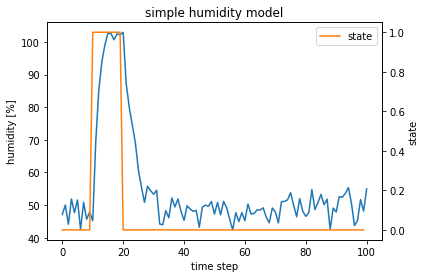

In [3]:
true_s = np.zeros(100)
true_s[10:20] = 1.0
x = gen_hum(true_s)

fig,ax = plt.subplots(1)
ax.plot(x, label='humidity')
ax.set_xlabel('time step'); ax.set_ylabel('humidity [%]')
ax.set_title('simple humidity model')
ax2 = ax.twinx()
ax2.plot(true_s, color='C1', label='state')
ax2.set_ylabel('state')
ax2.legend()

In [4]:
def humidity_latent_event_detection(x):
    """
        Max-sum (Viterbi) algorithm 
    """
    bg_hum = 60.0 # true value 50.0
    k1 = 0.29   # true value 0.25
    k2 = 0.4    # true value 0.5

    # transition probability s1->s2 = T[s1,s2]
    T = np.array([[0.9, 0.1], 
                  [0.1, 0.9]]) 

    N = len(x)-1

    s = np.zeros((N, 2))
    s_in_x = np.zeros((N, 2))
    s_sel = np.zeros((N, 2))

    # prepare messages from x[] 
    for n in range(N):
        for s_ in [0, 1]:
            x_ = x[n] + (1-s_)*k1*(bg_hum - x[n]) + s_*k2*(100. - x[n])
            s_in_x[n, s_] = np.log(norm.pdf(x[n+1], loc=x_, scale=5))

    # message passing to root node (s[0])
    s_ = np.zeros(2)
    s_in_ = np.zeros(2) # message from the future s[n]
    for n in reversed(range(N)):
        s_[0] = s_in_[0] + s_in_x[n,0]
        s_[1] = s_in_[1] + s_in_x[n,1]
        s_in_[0] = np.max([T[0,0]+s_[0], T[0,1]+s_[1]])
        s_in_[1] = np.max([T[1,0]+s_[0], T[1,1]+s_[1]])
        s_sel[n,0] = np.argmax([T[0,0]+s_[0], T[0,1]+s_[1]])
        s_sel[n,1] = np.argmax([T[1,0]+s_[0], T[1,1]+s_[1]])
        
    # decode (trace selected path)
    s = np.zeros(N)
    s[0] = 0
    for n in range(N-1):
        s[n+1] = s_sel[n+1,int(s[n])]

    return s

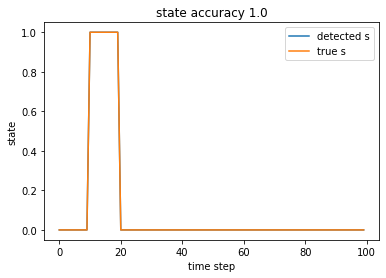

In [5]:
s = humidity_latent_event_detection(x)

fig,ax = plt.subplots(1)
ax.plot(s, label='detected s')
ax.plot(true_s, label='true s')
ax.set_xlabel('time step')
ax.set_ylabel('state')
accuracy = np.sum(s==true_s) / len(s)
ax.set_title(f'state accuracy {accuracy}')
ax.legend()